# Patch Prediction Models

<a href="https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/master/examples/05_example_patchpredictor.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/05_example_patchpredictor.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/></a>

_In order to run this notebook on a Kaggle platform, 1) click on the blue Kaggle badge saying Open in Kaggle 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

_If you are using google Colab, for faster responses you should enable the use of GPU for this session through (menu) Runtime ⟶ Change runtime type ⟶ Set "Hardware Accelator" to "GPU"._

# Welcome to TIAToolbox!

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. When running under Colab, there are useful icons in the lefthand margin—hover and click. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the 
[README](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/README.md#install-python-package) file.

### About this demo
In this example, we will show how to use TIAToolbox for patch-level prediction using a range of deep learning models. TIAToolbox can be used to make predictions on pre-extracted image patches or on larger image tiles / whole-slide images (WSIs), where image patches are extracted on the fly. WSI patch-level predictions can subsequently be aggregated to obtain a segmentation map. In particular, we will introduce the use of our module
`patch_predictor` ([details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/tiatoolbox/models/classification/patch_predictor.py)). A full list of the available models trained and provided in TIAToolbox for patch-level prediction is given below.

- Models trained on the Kather 100k dataset ([details](https://zenodo.org/record/1214456#.YJw4UEhKjvU)):
    - `alexnet-kather100k`
    - `resnet18-kather100k`
    - `resnet34-kather100k`
    - `resnet50-kather100k`
    - `resnet101-kather100k`
    - `resnext50_32x4d-kather100k`
    - `resnext101_32x8d-kather100k`
    - `wide_resnet50_2-kather100k`
    - `wide_resnet101_2-kather100k`
    - `densenet121-kather100k`
    - `densenet161-kather100k`
    - `densenet169-kather100k`
    - `densenet201-kather100k`
    - `mobilenet_v2-kather100k`
    - `mobilenet_v3_large-kather100k`
    - `mobilenet_v3_small-kather100k`
    - `googlenet-kather100k`

### Setting up the environment
The cell below removes some redundant directories if they exist—a previous run may have created them. This cell can be skipped if you are running this notebook for the first time.

In [ ]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )
![ -d tile_predictions ] && !( echo "deleting 'tile_predictions' directory"; rm -r tile_predictions)
![ -d wsi_predictions ] && ( echo "deleting 'wsi_predictions' directory"; rm -r wsi_predictions)
import warnings
warnings.filterwarnings('ignore')

You can skip this cell if 1) you are not using the Colab or Kaggle platform or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/README.md#install-python-package).)

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install --upgrade --ignore-installed --quiet git+https://github.com/TissueImageAnalytics/tiatoolbox/@develop | tail -n 1
ON_GPU=False
print('Installation is done.')

**[optional]**: if you are running this example notebook on your system and it is equipped with a Cuda enabled GPU, you can run the following cell to install the Cuda enabled version of `torch` package in order to utilize GPU computation and speed up the TIAToolbox models.

In [ ]:
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True

**[essential]** Please install the following packages as these will be required in this notebook in addition to TIAToolbox installation.

In [ ]:
!pip install seaborn

### Importing related libraries

We import some standard Python modules, and also the TIAToolbox Python modules for the patch classification task, written by the TIA Centre team.

In [4]:
from tiatoolbox.models.engine.patch_predictor import CNNPatchPredictor, IOPatchPredictorConfig
from tiatoolbox.utils.misc import imread, grab_files_from_dir
from tiatoolbox.utils.visualization import overlay_patch_prediction
from tiatoolbox.wsicore.wsireader import get_wsireader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams['figure.dpi'] = 160 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a sample subset of validation patches that were used when training models on the Kather 100k dataset, a sample image tile and a sample whole-slide image. Downloading is needed once in each Colab session and it should take less than 1 minute.
> In Colab, if you click the file's icon (see below) in the vertical toolbar on the left-hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 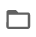

In [10]:
from tiatoolbox.utils.misc import download_data
from zipfile import ZipFile

img_file_name = "sample_tile.png"
wsi_file_name = "sample_wsi.svs"
patches_file_name = "kather100k-validation-sample.zip"
imagenet_samples_name = "imagenet_samples.zip"

print('Download has started. Please wait...')

# Downloading sample image tile
download_data("https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/CRC-Prim-HE-05_APPLICATION.tif", img_file_name)

# Downloading sample whole-slide image
download_data("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs", wsi_file_name)

# Download a sample of the validation set used to train the Kather 100K dataset
download_data("https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip", patches_file_name)
# Unzip it!
with ZipFile(patches_file_name, 'r') as zipObj:
   zipObj.extractall()

# Download some samples of imagenet to test the external models
download_data("https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/imagenet_samples.zip", imagenet_samples_name)
# Unzip it!
with ZipFile(imagenet_samples_name, 'r') as zipObj:
   zipObj.extractall()

print('Download is complete.')

Download has started. Please wait...
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/CRC-Prim-HE-05_APPLICATION.tif
Save to sample_tile.png
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs
Save to sample_wsi.svs
Download from https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip
Save to kather100k-validation-sample.zip
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/imagenet_samples.zip
Save to imagenet_samples.zip
Download is complete.


# Get predictions for a set of patches

Below we use `tiatoolbox` to obtain the model predictions for a set of patches with a pretrained model.

We use patches from the validation subset of [Kather 100k](https://zenodo.org/record/1214456#.YJ-tn3mSkuU) dataset. This dataset has already been downloaded in the download section above.
We first read the data and convert it to a suitable format. In particular, we create a list of patches and a list of corresponding labels.
For example, the first label in `label_list` will indicate the class of the first image patch in `patch_list`.

Class ID: 0 -- Class Name: BACK -- Number of images: 211
Class ID: 1 -- Class Name: NORM -- Number of images: 176
Class ID: 2 -- Class Name: DEB -- Number of images: 230
Class ID: 3 -- Class Name: TUM -- Number of images: 286
Class ID: 4 -- Class Name: ADI -- Number of images: 208
Class ID: 5 -- Class Name: MUC -- Number of images: 178
Class ID: 6 -- Class Name: MUS -- Number of images: 270
Class ID: 7 -- Class Name: STR -- Number of images: 209
Class ID: 8 -- Class Name: LYM -- Number of images: 232
Total number of patches: 2000


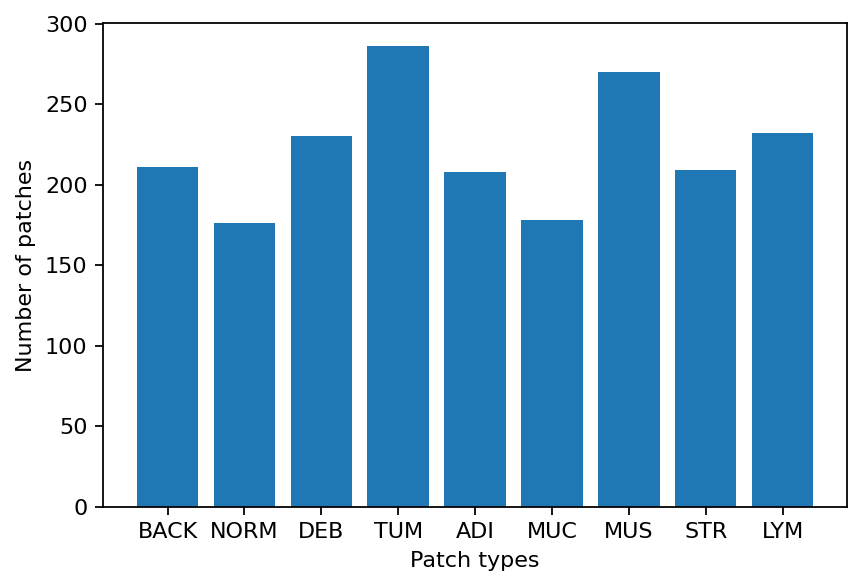

In [ ]:
# read the patch data and create a list of patches and a list of corresponding labels

dataset_path = './kather100k-validation-sample/' # set the path to the dataset
image_ext = '.tif'  # file extention of each image

# obtain the mapping between the label ID and the class name
label_dict = {'BACK':0, 'NORM':1, 'DEB':2, 'TUM': 3, 'ADI':4, 'MUC':5, 'MUS':6, 'STR':7, 'LYM':8}
class_names = list(label_dict.keys())
class_labels = list(label_dict.values())

# generate a list of patches and generate the label from the filename
patch_list = []
label_list = []
for class_name, label in label_dict.items():
    dataset_class_path = os.path.join(dataset_path, class_name)
    patch_list_single_class = grab_files_from_dir(dataset_class_path, file_types='*'+image_ext)
    patch_list.extend(patch_list_single_class)
    label_list.extend([label] * len(patch_list_single_class))


# show some dataset statistics
plt.bar(class_names, [label_list.count(label) for label in class_labels])
plt.xlabel('Patch types')
plt.ylabel('Number of patches')

# count the number of examples per class
for class_name, label in label_dict.items():
    print('Class ID: {} -- Class Name: {} -- Number of images: {}'.format(
        label, class_name, label_list.count(label)
    ))
    
    
# overall dataset statistics
print('Total number of patches: {}'.format(len(patch_list)))

As you can see for this patch dataset, we have 9 classes/labels with IDs 0-8 and associated class names. describing the dominant tissue type in the patch:
- BACK ⟶ Background (empty glass region)
- LYM  ⟶ Lymphocytes
- NORM ⟶ Normal colon mucosa
- DEB  ⟶ Debris
- MUS  ⟶ Smooth muscle
- STR  ⟶ Cancer-associated stroma
- ADI  ⟶ Adipose
- MUC  ⟶ Mucus 
- TUM  ⟶ Colorectal adenocarcinoma epithelium

It is easy to use this code for your dataset - just ensure that your dataset is arranged like this example (images of different classes are placed into different subfolders), and set the right image extension in the `image_ext` variable. 

## Predict patch labels in 2 lines of code
Now that we have the list of images, we can use TIAToolbox's `CNNPatchPredictor` to predict their category. First, we instantiate a predictor object and then we call the `predict` method to get the results.

In [ ]:
predictor = CNNPatchPredictor(pretrained_model='resnet18-kather100k', batch_size=32)
output = predictor.predict(imgs=patch_list, 
                           mode='patch', 
                           on_gpu=ON_GPU)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth
Save to /root/.tiatoolbox/models/resnet18-kather100k.pth


100%|###########################################| 63/63 [00:16<00:00,  3.83it/s]


Patch Prediction is Done!

The first line creates a CNN-based patch classifier instance based on the arguments and prepares a CNN model (generates the network, downloads pretrained weights, etc.). The CNN model used in this predictor can be defined using the `pretrained_model` argument. A complete list of supported pretrained classification models, that have been trained on the Kather 100K dataset, is reported in the first section of this notebook. `CNNPatchPredictor` also enables you to use your own pretrained models for your specific classification application. In order to do that, you might need to change some input arguments for `CNNPatchPredictor`, as we now explain:
- `model`: Use an externally defined PyTorch model for prediction, with weights already loaded. This is useful when you want to use your own pretrained model on your own data. The only constraint is that the input model should follow `tiatoolbox.models.abc.ModelABC` class structure. For more information on this matter, please refer to our [example notebook on advanced model techniques](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/07_advanced_model_techniques.ipynb).
- `pretrained_model `: This argument has already been discussed above. With it, you can tell tiatoolbox to use one of its pretrained models for the prediction task. A complete list of pretrained models can be found [here](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/tiatoolbox/models/architecture/__init__.py). If both `model` and `pretrained_model` arguments are used, then `pretrained_model`is ignored. In this example, we used `resnet18-kather100K,` which means that the model architecture is an 18 layer ResNet, trained on the Kather100k dataset.
- `pretrained_weight`: When using a `pretrained_model`, the corresponding pretrained weights will also be downloaded by default.  You can override the default with your own set of weights via the `pretrained_weight` argument.
- `batch_size`: Number of images fed into the model each time. Higher values for this parameter require a larger (GPU) memory capacity.

The second line in the snippet above calls the `predict` method to apply the CNN on the input patches and get the results. Here are some important `predict` input arguments and their descriptions:
- `mode`: Type of input to be processed. Choose from `patch`, `tile` or `wsi` according to your application. In this first example, we predict the tissue type of histology patches, so we use the `patch` option. The use of `tile` and `wsi` options are explained below. 
- `imgs`: List of inputs. When using `patch` mode, the input must be a list of images OR a list of image file paths, OR a Numpy array corresponding to an image list. However, for the `tile` and `wsi` modes, the `imgs` argument should be a list of paths to the input tiles or WSIs.
- `return_probabilities`: set to *__True__* to get per class probabilities alongside predicted labels of input patches. If you wish to merge the predictions to generate prediction maps for `tile` or `wsi` modes, you can set `return_probabilities=True`.

In the `patch` prediction mode, the `predict` method returns an output dictionary that contains the `predictions` (predicted labels) and `probabilities` (probability that a certain patch belongs to a  certain class).

The cell below uses common python tools to visualize the patch classification results in terms of classification accuracy and confusion matrix.

Classification accuracy: 0.993


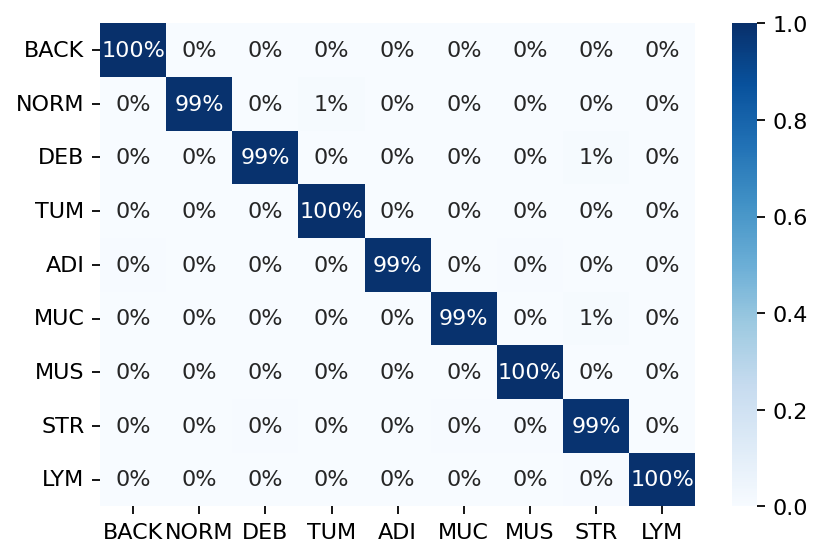

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

acc = accuracy_score(label_list, output['predictions'])
print('Classification accuracy: {}'.format(acc))

# Creating and visualizing the confusion matrix for patch classification results
conf = confusion_matrix(label_list, output['predictions'], normalize='true')
df_cm = pd.DataFrame(conf, index = class_names, columns = class_names)

# show confusion matrix
sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.0%')
plt.show()

Try changing the `pretrained_model` argument when making `CNNPatchPredictor` instant and see how it can affect the classification output accuracy.

# Get predictions for patches within an image tile

We now demonstrate how to obtain patch-level predictions for a large image tile. It is quite a common practice in computational pathology to divide a large image into several patches (often overlapping) and then aggregate the results to generate a prediction map for different regions of the large image. As we are making a prediction per patch again, there is no need to instantiate a new `CNNPatchPredictor` class. However, we should tune the `predict` input arguments to make them suitable for tile prediction. The `predict` function then automatically extracts patches from the large image tile and predicts the label for each of them. As the `predict` function can accept multiple tiles in the input to be processed and each input tile has potentially many patches, we save results in a file when more than one image is provided. This is done to avoid any problems with limited computer memory. However, if only one image is provided, the results will be returned in the same way that is done in `patch` mode.

Now, we try this function on a sample image tile. For this example, we use a tile that was released with the [Kather et al. 2016](https://doi.org/10.1038/srep27988) paper. It has been already downloaded in the Download section of this notebook.

Let's take look.

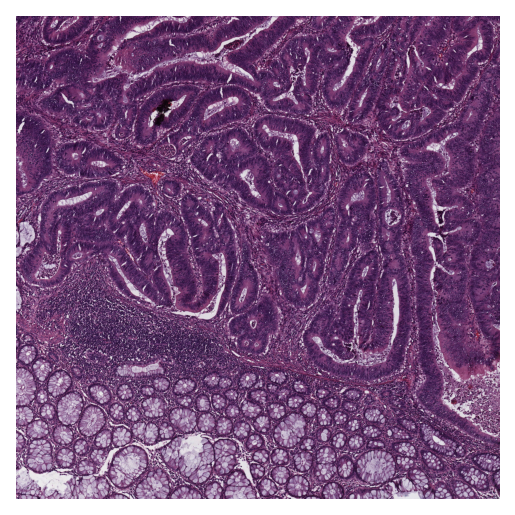

Tile size is: (5000, 5000, 3)


In [ ]:
# reading and displaying a tile image
input_tile = imread(img_file_name)

plt.imshow(input_tile)
plt.axis('off')
plt.show()

print('Tile size is: {}'.format(input_tile.shape))

 ## Patch-level prediction in 2 lines of code for big histology tiles
As you can see, the size of the tile image is 5000x5000 pixels. This is quite big and might result in computer memory problems if fed directly into a deep learning model. However, the `predict` method of `CNNPatchPredictor` handles this big tile seamlessly by processing small patches independently. You only need to change the `mode` argument to `tile` and a couple of other arguments, as explained below.

In [ ]:
predictor = CNNPatchPredictor(pretrained_model='resnet18-kather100k', batch_size=32)
tile_output = predictor.predict(imgs=[img_file_name],
                                mode='tile',
                                merge_predictions=True,
                                patch_input_shape=[224, 224],
                                stride_shape=[224, 224],
                                resolution=1,
                                units="baseline",
                                return_probabilities=True,
                                save_dir='./tile_predictions/',
                                on_gpu=ON_GPU)

|2021-11-04|15:22:18.735| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/engine/patch_predictor.py:499: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  "WSIPatchDataset only reads image tile at "

|2021-11-04|15:22:18.740| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/dataset/classification.py:237: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"` and `resolution=1.0`.
  "WSIPatchDataset only reads image tile at "



Download from https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth
Save to /root/.tiatoolbox/models/resnet18-kather100k.pth


|2021-11-04|15:22:19.490| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsimeta.py:171: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

100%|###########################################| 17/17 [00:03<00:00,  4.36it/s]
|2021-11-04|15:22:24.194| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/engine/patch_predictor.py:218: UserWarning: Image is not pyramidal hence read is forced to be at `units='baseline'` and `resolution=1.0`.
  "Image is not pyramidal hence read is forced to be "

|2021-11-04|15:22:24.197| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsimeta.py:174: UserWarning: Unknown scale (no objective_power or mpp)
  warnings.warn("Unknown scale (no objective_power or mpp)")



The new arguments in the input of `predict` method are:
- `mode='tile'`: the type of image input. We use `tile` since our input is a large image tile.
- `imgs`: in tile mode, the input is ***required*** to be a list of file paths.
- `save_dir`:  Output directory when processing multiple tiles. We explained before why this is necessary when we are working with multiple big tiles.
- `patch_size`: This parameter sets the size of patches (in [W, H] format) to be extracted from the input files, and for which labels will be predicted.
- `stride_size`: The stride (in [W, H] format) to consider when extracting patches from the tile. Using a stride smaller than the patch size results in overlapping between consecutive patches.
- `labels` (optional): List of labels with the same size as `imgs` that refers to the label of each input tile (not to be confused with the prediction of each patch).

In this example, we input only one tile. Therefore the toolbox does not save the output as files and instead returns a list that contains an output dictionary with the following keys:
- `coordinates`: List of coordinates of extracted patches in the following format: `[x_min, y_min, x_max, y_max]`. These coordinates can be used to later extract the same region from the input tile/WSI or regenerate a prediction map based on the `prediction` labels for each patch
- `predictions`: List of predicted labels for each of the tile's patches.
- `label`: Label of the tile generalized to each patch.

Keep in mind that if we had several items in the `imgs` input, then the result would be saved in JSON format at the specified `save_dir` and the returned output will be a list of paths to each of the saved JSON files

Now, we visualize some patch-level results.

### Visualisation of tile results

Below we will show some of the results generated by our patch-level predictor on the input image tile. First, we will show some individual patch predictions and then we will show the merged patch level results on the entire image tile.

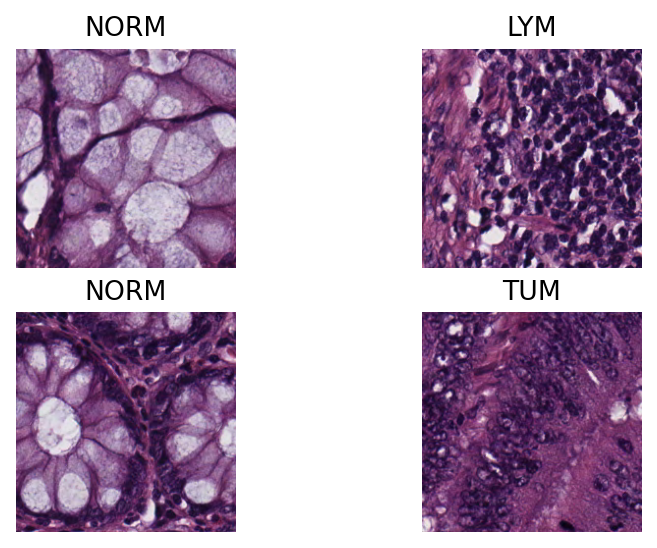

In [ ]:
# individual patch predictions sampled from the image tile

# extract the information from output dictionary
coordinates = tile_output[0]['coordinates']
predictions = tile_output[0]['predictions']

# select 4 random indices (patches)
random_idx = np.random.randint(0 , len(predictions), (4,))

for i, idx in enumerate(random_idx):
  this_coord = coordinates[idx]
  this_prediction = predictions[idx]
  this_class = class_names[this_prediction]

  this_patch = input_tile[this_coord[1]: this_coord[3], this_coord[0]: this_coord[2]]
  plt.subplot(2,2,i+1), plt.imshow(this_patch)
  plt.axis('off')
  plt.title(this_class)

Here, we show a prediction map where each colour denotes a different predicted category. We overlay the prediction map on the original image. To generate this prediction map, we utilize the `merge_predictions` method from the `CNNPatchPredictor` class which accepts as arguments the path of the original image, `predictor` outputs, `mode` (set to `tile` or `wsi`), `tile_resolution` (at which tiles were originally extracted)  and `resolution` (at which the prediction map is generated), and outputs the "Prediction map", in which regions have indexed values based on their classes.

To visualize the prediction map as an overlay on the input image, we use the`overlay_patch_prediction`function from the `tiatoolbox.utils.visualization` module. It accepts as arguments the original image, the prediction map, the `alpha` parameter which specifies the blending ratio of overlay and original image, and the `label_info` dictionary which contains names and desired colours for different classes. Below we generate an example of an acceptable `label_info` dictionary and show how it can be used with `overlay_patch_prediction`.

|2021-11-04|15:23:22.385| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/engine/patch_predictor.py:218: UserWarning: Image is not pyramidal hence read is forced to be at `units='baseline'` and `resolution=1.0`.
  "Image is not pyramidal hence read is forced to be "

|2021-11-04|15:23:22.390| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsimeta.py:171: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2021-11-04|15:23:22.394| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsimeta.py:174: UserWarning: Unknown scale (no objective_power or mpp)
  warnings.warn("Unknown scale (no objective_power or mpp)")



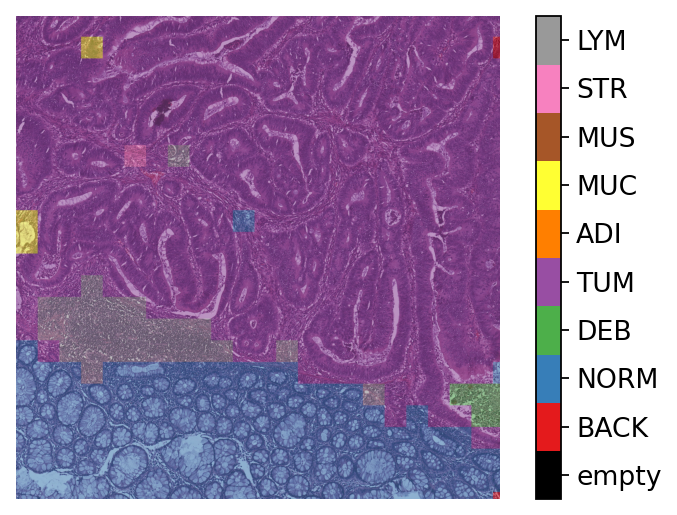

In [ ]:
# visualization of merged image tile patch-level prediction.
from matplotlib import cm

tile_output[0]['resolution']=1.0
tile_output[0]['units']='baseline'

label_color_dict = {}
label_color_dict[0] = ('empty', (0,0,0))
colors = cm.get_cmap('Set1').colors
for class_name, label in label_dict.items():
    label_color_dict[label+1] = (class_name, 255*np.array(colors[label]))
pred_map = predictor.merge_predictions(img_file_name, tile_output[0], resolution=1, units='baseline')
overlay = overlay_patch_prediction(input_tile, pred_map, alpha=0.5, label_info=label_color_dict)
plt.show()


Note that `overlay_patch_prediction` returns a figure handler, so that `plt.show()` or `plt.savefig()` shows or, respectively, saves the overlay figure generated. Now go back and predict with a different `stride_size` or `pretrained_model` to see what effect this has on the output.

# Get predictions for patches within a WSI

We demonstrate how to obtain predictions for all patches within a     whole-slide image. As in previous sections, we will use `CNNPatchPredictor` and its `predict` method, but this time we set the `mode` to `'wsi'`. We also introduce `IOPatchPredictorConfig`, a class that specifies the configuration of image reading and prediction writing for the model prediction engine. 

In [ ]:
wsi_ioconfig = IOPatchPredictorConfig(
    input_resolutions=[
            {'units': 'mpp', 'resolution': 0.5}
        ],
        patch_input_shape=[224, 224],
        stride_shape=[224, 224],
)

Parameters of `IOPatchPredictorConfig` have self-explanatory names, but let's have look at their definition:
- `input_resolutions`: a list specifying the resolution of each input head of model in the form of a dictionary. List elements must be in the same order as target `model.forward()`. Of course, if your model accepts only one input, you just need to put one dictionary specifying `'units'` and `'resolution'`. But it's good to know that TIAToolbox supports a model with more than one input.
- `patch_input_shape`: Shape of the largest input in (height, width) format.
- `stride_shape`: the size of stride (steps) between two consecutive patches, used in the patch extraction process. If the user sets `stride_shape` equal to `patch_input_shape`, patches will be extracted and processed without any overlap.

Now that we have set everything, we try our patch predictor on a WSI. Here, we use a large WSI and therefore the patch extraction and prediction processes may take some time (make sure to set the `ON_GPU=True` if you have access to Cuda enabled GPU and Pytorch+Cuda).

In [ ]:
predictor = CNNPatchPredictor(pretrained_model='resnet18-kather100k', batch_size=64)
wsi_output = predictor.predict(imgs=[wsi_file_name],
                              masks=None,
                              mode='wsi',
                              merge_predictions=False,
                              ioconfig=wsi_ioconfig,
                              return_probabilities=True,
                              save_dir='./wsi_predictions/',
                              on_gpu=ON_GPU)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth
Save to /root/.tiatoolbox/models/resnet18-kather100k.pth


|2021-11-04|16:24:13.037| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsireader.py:306: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."

100%|#########################################| 318/318 [05:35<00:00,  1.05s/it]


We introduce some new arguments for `predict` method:
- `mode`: set to 'wsi' when analysing whole slide images.
- `ioconfig`: set the IO configuration information using the `IOPatchPredictorConfig` class.
- `resolution` and `unit` (not shown above): These arguments specify the level or micron-per-pixel resolution of the WSI levels from which we plan to extract patches and can be used instead of `ioconfig`. Here we specify the WSI's level as `'baseline'`, which is equivalent to level 0. In general, this is the level of greatest resolution. In this particular case, the image has only one level. More information can be found in the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=WSIReader.read_rect#tiatoolbox.wsicore.wsireader.WSIReader.read_rect). 
- `masks`: A list of paths corresponding to the masks of WSIs in the     `imgs` list. These masks specify the regions in the original WSIs from which we want to extract patches. If the mask of a particular WSI is specified as `None`, then the labels for all patches of that WSI (even background regions)  would be predicted. This could cause unnecessary computation.
-`merge_predictions`: You can set this parameter to `True` if you wish to generate a 2D map of patch classification results. However, for big WSIs you might need a large amount of memory available to do this on the file. An alternative (default) solution is to set `merge_predictions=False`, and then generate the 2D prediction maps using `merge_predictions` function as you will see later on.

We see how the prediction model works on our whole-slide images by visualizing the `wsi_output`. We first need to merge patch prediction outputs and then visualize them as an overlay on the original image. As before, the `merge_predictions` method is used to merge the patch predictions. Here we set the parameters `resolution=1.25, units='power'` to generate the prediction map at 1.25x magnification. If you would like to have higher/lower resolution (bigger/smaller) prediction maps, you need to change these parameters accordingly. When the predictions are merged, use the `overlay_patch_prediction` function to overlay the prediction map on the WSI thumbnail, which should be extracted at the same resolution used for prediction merging. Below you can see the result:

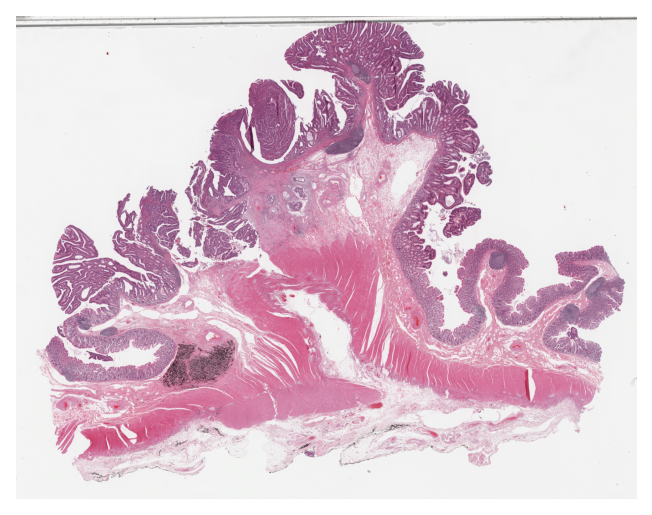

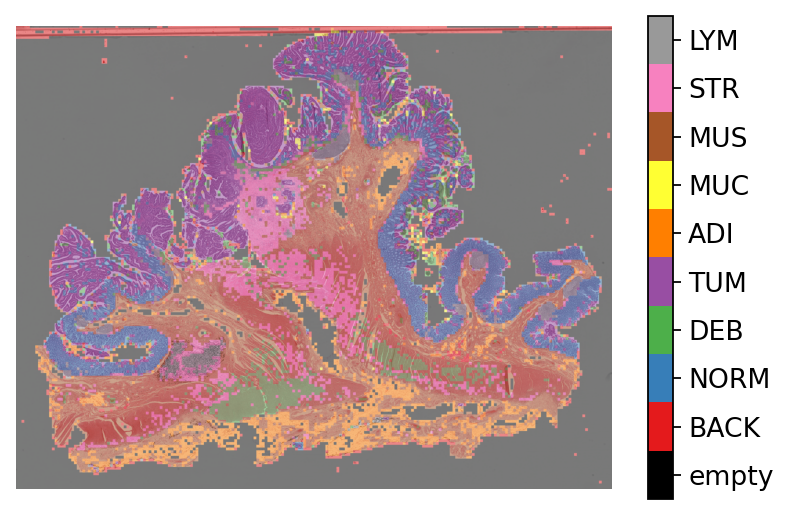

In [ ]:
# visualization of whole-slide image patch-level prediction
overview_resolution = 4 # the resolution in which we desire to merge and visualize the patch predictions
overview_unit = "mpp" # the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"
wsi = get_wsireader(wsi_file_name)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview); plt.axis('off')

pred_map = predictor.merge_predictions(wsi_file_name, wsi_output[0], resolution=overview_resolution, units=overview_unit)
overlay = overlay_patch_prediction(wsi_overview, pred_map, alpha=0.5, label_info=label_color_dict)
plt.show()

In this notebook, we show how we can use the `CNNPatchPredictor` class and its `predict` method to predict the label for patches of big tiles and WSIs. We introduce `merge_predictions` and `overlay_patch_prediction` helper functions that merge the patch prediction outputs and visualize the resulting prediction map as an overlay on the input image/WSI.

All the processes take place within the TIAToolbox and you can easily put the pieces together, following our example code. Just make sure to set inputs and options correctly. We encourage you to further investigate the effect on the prediction output of changing `predict` function parameters.